In [13]:
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
import pickle

In [17]:
gradients = nb.load("/home/julia/data/gradients/results/embedding_vol/embed.nii.gz").get_data()
mask = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz").get_data()
pv = nb.load("/home/julia/data/gradients/atlas/interneurons/pv2allen.nii.gz").get_data()
sst = nb.load("/home/julia/data/gradients/atlas/interneurons/sst2allen.nii.gz").get_data()
vip = nb.load("/home/julia/data/gradients/atlas/interneurons/vip2allen.nii.gz").get_data()

In [18]:
pv_sst = np.zeros_like(mask)
pv_sst[mask==1] = pv[mask==1]/(pv[mask==1]+sst[mask==1])
aff = nb.load("/home/julia/data/gradients/atlas/interneurons/pv2allen.nii.gz").affine
nb.save(nb.Nifti1Image(pv_sst, aff), "/home/julia/data/gradients/atlas/interneurons/pv_sst2allen.nii.gz")

In [21]:
names = ["pv", "sst", "vip", "pv_sst"]
images = [pv, sst, vip, pv_sst]
for g in range(6):
    for i in range(len(images)):
        r = stats.spearmanr(gradients[:,:,:,g][mask==1], images[i][mask==1])
        if r[1]<0.05:
            if np.abs(r[0])>0.3:
                print('Gradient %i, %s:' %(g, names[i]), r)

Gradient 2, pv_sst: SpearmanrResult(correlation=0.34228398442944208, pvalue=0.0)
Gradient 4, pv_sst: SpearmanrResult(correlation=-0.3454123532285871, pvalue=0.0)


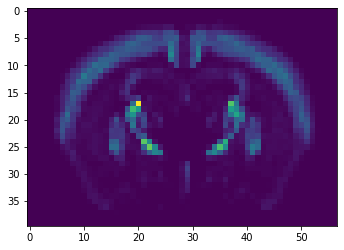

In [7]:
plt.imshow(pv[30,:,:])

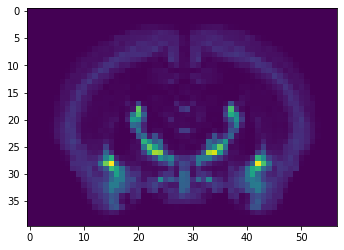

In [8]:
plt.imshow(sst[30,:,:])

(array([  874.,  1292.,  1438.,  2047.,  3011.,  3351.,  2159.,   506.,
           62.,    53.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

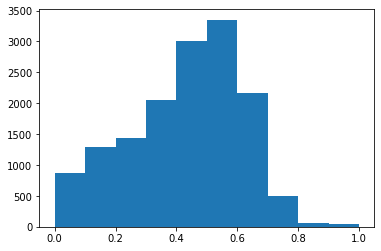

In [9]:
plt.hist(pv_sst[mask==1], range=(0,1))

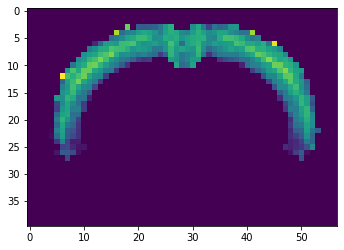

In [10]:
plt.imshow((pv_sst)[30,:,:],vmin=0, vmax=1)

### Interneurons by clusters

In [22]:
df = pd.read_csv('/home/julia/data/gradients/results/regions/finest_regions.csv')
df = df.drop(columns=['Unnamed: 0', 'comment'])
df = df.dropna()
df = df.reindex()
annot = np.array(nb.load('/home/julia/data/gradients/atlas/allen_api/regions/annot_finest_200um.nii.gz').get_data(), dtype='float64')

In [23]:
for i in range(len(images)):
    i_masked = images[i]
    i_masked[mask==0] = np.nan
    
    i_dict = {}
    for region in df['id']:
        acronym = df.loc[df['id']==region, 'acronym'].values[0]
        i_dict[acronym] = i_masked[annot==region]
        
    with open('/home/julia/data/gradients/results/regions/%s_by_cluster.pkl' % names[i], 'wb') as f:
        pickle.dump(i_dict, f)

### Plotting

In [24]:
df.loc[df['acronym']=='MOp', 'cluster'] = 'motor'
df.loc[df['acronym']=='MOs', 'cluster'] = 'motor'
df.loc[df['cluster']=='somatomotor', 'cluster'] = 'somatosensory'

In [25]:
with open('/home/julia/data/gradients/results/regions/pv_by_cluster.pkl', 'rb') as f:
    pv = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/sst_by_cluster.pkl', 'rb') as f:
    sst = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/vip_by_cluster.pkl', 'rb') as f:
    vip = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/pv_sst_by_cluster.pkl', 'rb') as f:
    pv_sst = pickle.load(f)

In [26]:
with open('/home/julia/data/gradients/results/regions/gradient2_by_cluster.pkl', 'rb') as f:
    g2 = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/gradient4_by_cluster.pkl', 'rb') as f:
    g4 = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/gradient1_by_cluster.pkl', 'rb') as f:
    g1 = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/gradient3_by_cluster.pkl', 'rb') as f:
    g3 = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/gradient0_by_cluster.pkl', 'rb') as f:
    g0 = pickle.load(f)
with open('/home/julia/data/gradients/results/regions/gradient5_by_cluster.pkl', 'rb') as f:
    g5 = pickle.load(f)

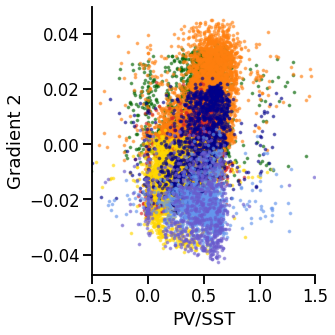

In [32]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df.loc[df['cluster']==clusters[c], 'acronym'])
    for r in regions:
        plt.scatter(pv_sst[r], g2[r], color=colors[c], label=clusters[c], alpha=0.5, s=5)
plt.xlim(-0.5,1.5)
plt.xlabel('PV/SST')
plt.ylabel('Gradient 2')
plt.tight_layout()
sns.despine()

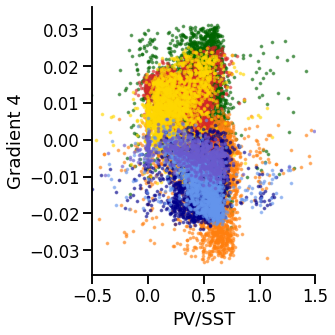

In [33]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df.loc[df['cluster']==clusters[c], 'acronym'])
    for r in regions:
        plt.scatter(pv_sst[r], g4[r], color=colors[c], label=clusters[c], alpha=0.5, s=5)
plt.xlim(-0.5,1.5)
plt.xlabel('PV/SST')
plt.ylabel('Gradient 4')
plt.tight_layout()
sns.despine()